# Uber/Lyft Ride Price Estimator
<img src="http://media-dmg.assets-cdk.com/teams/repository/export/v/2/665/1b7608a1910058176005056925fd3/6651b7608a1910058176005056925fd3.png" alt="uber lyft logo" title="Uber Lyft" />
Run function get_estimates() to retrieve price estimates from Uber and Lyft using their respective apis. You will need to have an uber api key to retrieve prices from uber. This notebook contains a demonstration of what the price_estimator.py script can do.

In [1]:
# import libraries
from geopy.geocoders import Nominatim
from uber_rides.session import Session
from uber_rides.client import UberRidesClient
import pandas as pd
import urllib2
import matplotlib.pyplot as plt
import seaborn as sns
import json
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# enter in session key for uber api at server token space
session = Session(server_token='##############')
client = UberRidesClient(session)
# starting address
geolocator = Nominatim()

In [3]:
class price_estimator():
    def __init__(self):
        try:
            self.start = raw_input('enter start address: ')
            self.end = raw_input('enter destination address: ')
            self.startad = geolocator.geocode(self.start).address
            self.endad = geolocator.geocode(self.end).address
            print '\nstart address: '
            print self.startad
            print '\nend address: '
            print self.endad
            self.verification = raw_input('\nis this information correct? (y/n): ')
        except:
            print 'Something went wrong! Try verifying your address'
    def starter(self):
        if self.verification=='y':
            
            # get coordinates
            start=geolocator.geocode(self.start)
            end=geolocator.geocode(self.end)
            
            start_lat, start_lon = start.latitude, start.longitude
            end_lat, end_lon = end.latitude, end.longitude
            
            #get response from uber
            response = client.get_price_estimates(
            start_latitude=start_lat,
            start_longitude=start_lon,
            end_latitude=end_lat,
            end_longitude=end_lon,
            seat_count=2
            )
            estimate = response.json.get('prices')
            # get uber df
            uber_df=pd.DataFrame(estimate).sort_values(by='high_estimate')
            uber_df['display_name']=uber_df['display_name'].apply(lambda x: 'uber'+x if 'uber' not in x else x)
            #get lyft response
            url = 'https://api.lyft.com/v1/cost?start_lat={}&start_lng={}&end_lat={}&end_lng={}'.format(start_lat,start_lon,end_lat,end_lon)
            response = urllib2.urlopen(url)
            data = json.loads(response.read())
            # get lyft df
            lyft_df=pd.DataFrame(data['cost_estimates']).sort_values(by='estimated_cost_cents_min')
            lyft_df['high_estimate']=lyft_df['estimated_cost_cents_max'].apply(lambda x: x/100.)
            lyft_df['low_estimate']=lyft_df['estimated_cost_cents_min'].apply(lambda x: x/100.)
            # get summary of rates and plot rates
            summary_df=pd.concat([lyft_df[['display_name','low_estimate','high_estimate']],uber_df[['display_name','low_estimate','high_estimate']]]).sort_values(by='low_estimate')
            print '\n\nRate Summary Ordered by Cheapest Low Estimate'
            print summary_df
            plt.figure(figsize=(15,10))
            plt.title('Rate Summary')
            ax=sns.barplot(y=summary_df['display_name'],x=summary_df['low_estimate'],orient='h')
            for p in ax.patches:
                width = p.get_width()
                plt.text(0.25+p.get_width(), p.get_y()+0.55*p.get_height(),
                         '{:1.2f}'.format(width),ha='left', va='center') 
            plt.show()
        else:
            print 'Please adjust address'

def get_estimates():
    test=price_estimator()
    return test.starter()

enter start address: valley fair san jose california
enter destination address: los gatos california

start address: 
Valley Fair, Forest Avenue, Rose Garden, San José, Santa Clara County, California, 95128, United States of America

end address: 
Los Gatos, Santa Clara County, California, United States of America

is this information correct? (y/n): y


Rate Summary Ordered by Cheapest Low Estimate
   display_name  low_estimate  high_estimate
0     Lyft Line         15.50          15.50
6      uberPOOL         16.00          21.00
4    uberASSIST         17.00          22.00
5       uberWAV         17.00          22.00
7         uberX         17.00          22.00
1          Lyft         18.34          18.34
1        uberXL         21.00          27.00
2     Lyft Plus         27.25          27.25
0    uberSELECT         32.00          40.00
3  Lyft Premier         41.14          41.14
2     uberBLACK         46.00          57.00
3       uberSUV         55.00          69.00
4      Lyft 

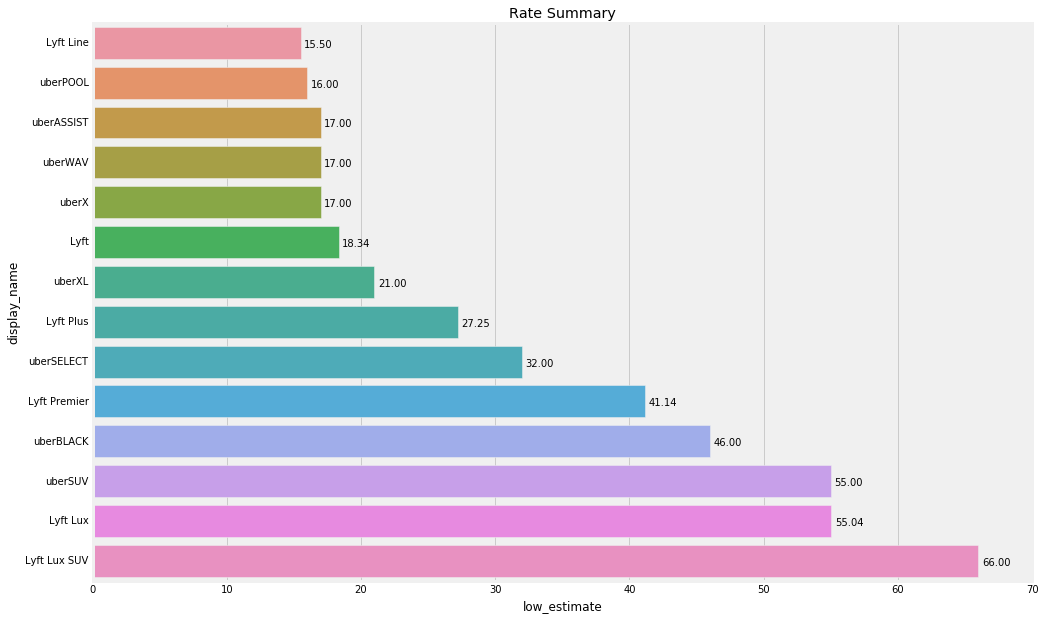

In [10]:
get_estimates()